In [1]:
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn import svm, cross_validation, metrics, preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.externals import joblib
import seaborn as sb

client = pymongo.MongoClient()
db = client.VentDB
validData = db.train_collection

%matplotlib inline

In [2]:
validData.find({'validation':{'$exists':1}}).count()

1873

In [3]:
data = validData.find({'validation':{'$exists':1}}, {'validation':1, 'breath_character':1, 'breath_settings':1, 
                                                     'max_min_analysis':1, 'next_breath_data':1, '_id':0})
df = pd.io.json.json_normalize(list(data))

In [4]:
list(df.columns)

['breath_character.elapse_time',
 'breath_character.end_insp_flow',
 'breath_character.end_insp_paw',
 'breath_character.end_insp_time',
 'breath_character.end_insp_vol',
 'breath_character.end_time',
 'breath_character.exp_time',
 'breath_character.insp_time',
 'breath_character.mean_exp_flow',
 'breath_character.mean_exp_paw',
 'breath_character.mean_insp_flow',
 'breath_character.mean_insp_paw',
 'breath_character.min_exp_flow',
 'breath_character.min_exp_paw',
 'breath_character.min_exp_vol',
 'breath_character.min_flow',
 'breath_character.min_paw',
 'breath_character.min_vol',
 'breath_character.n_dF/dP_exp_max',
 'breath_character.n_dF/dP_insp_max',
 'breath_character.n_dF/dV_exp_max',
 'breath_character.n_dF/dV_insp_max',
 'breath_character.n_dP/dV_exp_max',
 'breath_character.n_dP/dV_insp_max',
 'breath_character.peak_flow',
 'breath_character.peak_paw',
 'breath_character.peak_vol',
 'breath_character.start_time',
 'breath_settings.auto_peep',
 'breath_settings.compliance',
 

In [5]:
for x in range(15):
    print(df.columns[(x*10):(x*10+10)])

Index(['breath_character.elapse_time', 'breath_character.end_insp_flow',
       'breath_character.end_insp_paw', 'breath_character.end_insp_time',
       'breath_character.end_insp_vol', 'breath_character.end_time',
       'breath_character.exp_time', 'breath_character.insp_time',
       'breath_character.mean_exp_flow', 'breath_character.mean_exp_paw'],
      dtype='object')
Index(['breath_character.mean_insp_flow', 'breath_character.mean_insp_paw',
       'breath_character.min_exp_flow', 'breath_character.min_exp_paw',
       'breath_character.min_exp_vol', 'breath_character.min_flow',
       'breath_character.min_paw', 'breath_character.min_vol',
       'breath_character.n_dF/dP_exp_max',
       'breath_character.n_dF/dP_insp_max'],
      dtype='object')
Index(['breath_character.n_dF/dV_exp_max', 'breath_character.n_dF/dV_insp_max',
       'breath_character.n_dP/dV_exp_max', 'breath_character.n_dP/dV_insp_max',
       'breath_character.peak_flow', 'breath_character.peak_paw',
      

In [6]:
df.replace({np.nan:0}, inplace=True)
df['breath_settings.vent_mode'] = df['breath_settings.vent_mode'].astype('category')
print(df['breath_settings.vent_mode'].value_counts)
df = df[(df['breath_settings.vent_mode'] == 'APVCMV') | (df['breath_settings.vent_mode'] == 'PCMV')]
df.drop(['breath_settings.vent_mode', 'breath_settings.i:e', 'breath_settings.file'], inplace=True, axis=1)
df.shape

<bound method IndexOpsMixin.value_counts of 0        SPONT
1       APVCMV
2       APVCMV
3       APVCMV
4       APVCMV
5       APVCMV
6        SPONT
7        SPONT
8       APVCMV
9        SPONT
10        PCMV
11      APVCMV
12      APVCMV
13      APVCMV
14      APVCMV
15      APVCMV
16      APVCMV
17      APVCMV
18      APVCMV
19      APVCMV
20      APVCMV
21      APVCMV
22        PCMV
23      APVCMV
24      APVCMV
25        PCMV
26      APVCMV
27      APVCMV
28      APVCMV
29      APVCMV
         ...  
1843    APVCMV
1844    APVCMV
1845    APVCMV
1846     SPONT
1847    APVCMV
1848    APVCMV
1849    APVCMV
1850    APVCMV
1851    APVCMV
1852    APVCMV
1853    APVCMV
1854    APVCMV
1855    APVCMV
1856    APVCMV
1857    APVCMV
1858    APVCMV
1859    APVCMV
1860    APVCMV
1861    APVCMV
1862    APVCMV
1863    APVCMV
1864    APVCMV
1865    APVCMV
1866    APVCMV
1867    APVCMV
1868    APVCMV
1869      APRV
1870    APVCMV
1871    APVCMV
1872    APVCMV
Name: breath_settings.vent_mode, dtype: c

(1638, 183)

In [7]:
df = df[(df['breath_character.peak_vol'] < 2000) & (df['breath_character.peak_vol'] > 100) & (df['breath_character.elapse_time'] < 6000)]
df.shape

(1580, 183)

In [8]:
use_norms = True

if use_norms == True:
    clf = joblib.load('c:\\Research_data\\VD_models\\norm\\norm.pkl')
    scaler = joblib.load('c:\\Research_data\\VD_models\\norm\\norm_scaler.pkl')
    cols = joblib.load('c:\\Research_data\\VD_models\\norm\\norm_cols.pkl')
    
    df['norm_predict'] = clf.predict(scaler.transform(df[cols].values))

In [38]:
norm_cols = ['breath_character.elapse_time',
             'breath_character.end_insp_flow',
             'breath_character.end_insp_paw',
             'breath_character.end_insp_vol',
             'breath_character.exp_time',
             'breath_character.insp_time',
             'breath_character.mean_exp_flow',
             'breath_character.mean_exp_paw',
             'breath_character.mean_insp_flow',
             'breath_character.mean_insp_paw',
             'breath_character.min_exp_flow',
             'breath_character.min_exp_paw',
             'breath_character.min_exp_vol',
             'breath_character.min_flow',
             'breath_character.min_paw',
             'breath_character.min_vol',
             'breath_character.n_dF/dP_exp_max',
             'breath_character.n_dF/dP_insp_max',
             'breath_character.n_dF/dV_exp_max',
             'breath_character.n_dF/dV_insp_max',
             'breath_character.n_dP/dV_exp_max',
             'breath_character.n_dP/dV_insp_max',
             'breath_character.peak_flow',
             'breath_character.peak_paw',
             'breath_settings.exp_flow',
             'breath_settings.exp_minute_vol',
             'breath_settings.fio2',
             'breath_settings.insp_flow',
             'breath_settings.insp_paw',
             'breath_settings.mean_paw',
             'breath_settings.min_paw',
             'breath_settings.peak_flow',
             'breath_settings.peak_paw',
             'breath_settings.peep',
             'breath_settings.rr',
             'breath_settings.set_VT',
             'breath_settings.t_exp',
             'breath_settings.t_insp',
             'breath_settings.vte',
             'breath_settings.vti',
             'max_min_analysis.sm_flow.delta_insp_max',
             'max_min_analysis.sm_flow.delta_insp_max_25',
             'max_min_analysis.sm_flow.delta_insp_max_50',
             'max_min_analysis.sm_flow.delta_insp_max_75',
             'max_min_analysis.sm_flow.insp_25_max',
             'max_min_analysis.sm_flow.insp_50_max',
             'max_min_analysis.sm_flow.insp_75_max',
             'max_min_analysis.sm_flow.insp_ptp_max_delta',
             'max_min_analysis.sm_flow.insp_ptp_rel_position',
             'max_min_analysis.sm_flow.insp_ptp_time_delta',
             'max_min_analysis.sm_flow.insp_rise',
             'max_min_analysis.sm_flow.insp_rise_25',
             'max_min_analysis.sm_flow.insp_rise_50',
             'max_min_analysis.sm_flow.insp_rise_75',
             'max_min_analysis.sm_flow.n_exp_max',
             'max_min_analysis.sm_flow.n_exp_max_15',
             'max_min_analysis.sm_flow.n_exp_max_25',
             'max_min_analysis.sm_flow.n_exp_max_50',
             'max_min_analysis.sm_flow.n_exp_max_75',
             'max_min_analysis.sm_flow.n_insp_max',
             'max_min_analysis.sm_flow.n_insp_max_25',
             'max_min_analysis.sm_flow.n_insp_max_50',
             'max_min_analysis.sm_flow.n_insp_max_75',
             'max_min_analysis.sm_flow.n_insp_max_90',
             'max_min_analysis.sm_flow.n_insp_min',
             'max_min_analysis.sm_flow.n_insp_min_25',
             'max_min_analysis.sm_flow.n_insp_min_50',
             'max_min_analysis.sm_flow.n_insp_min_75',
             'max_min_analysis.sm_flow.shoulder_amp',
             'max_min_analysis.sm_flow.shoulder_time',
             'max_min_analysis.sm_flow.shoulder_time_percent',
             'max_min_analysis.sm_paw.delta_insp_max',
             'max_min_analysis.sm_paw.delta_insp_max_25',
             'max_min_analysis.sm_paw.delta_insp_max_50',
             'max_min_analysis.sm_paw.delta_insp_max_75',
             'max_min_analysis.sm_paw.insp_25_max',
             'max_min_analysis.sm_paw.insp_50_max',
             'max_min_analysis.sm_paw.insp_75_max',
             'max_min_analysis.sm_paw.insp_ptp_max_delta',
             'max_min_analysis.sm_paw.insp_ptp_rel_position',
             'max_min_analysis.sm_paw.insp_ptp_time_delta',
             'max_min_analysis.sm_paw.insp_rise',
             'max_min_analysis.sm_paw.insp_rise_25',
             'max_min_analysis.sm_paw.insp_rise_50',
             'max_min_analysis.sm_paw.insp_rise_75',
             'max_min_analysis.sm_paw.n_exp_max',
             'max_min_analysis.sm_paw.n_exp_max_15',
             'max_min_analysis.sm_paw.n_exp_max_25',
             'max_min_analysis.sm_paw.n_exp_max_50',
             'max_min_analysis.sm_paw.n_exp_max_75',
             'max_min_analysis.sm_paw.n_insp_max',
             'max_min_analysis.sm_paw.n_insp_max_25',
             'max_min_analysis.sm_paw.n_insp_max_50',
             'max_min_analysis.sm_paw.n_insp_max_75',
             'max_min_analysis.sm_paw.n_insp_max_90',
             'max_min_analysis.sm_paw.n_insp_min',
             'max_min_analysis.sm_paw.n_insp_min_25',
             'max_min_analysis.sm_paw.n_insp_min_50',
             'max_min_analysis.sm_paw.n_insp_min_75',
             'max_min_analysis.sm_paw.shoulder_amp',
             'max_min_analysis.sm_paw.shoulder_time',
             'max_min_analysis.sm_paw.shoulder_time_percent']

ds_cols = [ 'breath_character.insp_time',
            'breath_character.exp_time', 
            'breath_character.elapse_time', 
            'breath_character.min_exp_vol', 
            'breath_character.min_vol',
            'next_breath_data.min_exp_vol',
            ]

pfl_cols = [ 'norm_predict',
             'breath_character.elapse_time',
             'breath_character.end_insp_flow',
             'breath_character.end_insp_paw',
             'breath_character.end_insp_vol',
             'breath_character.insp_time',
             'breath_character.mean_insp_flow',
             'breath_character.mean_insp_paw',
             'breath_character.min_flow',
             'breath_character.min_paw',
             'breath_character.min_vol',
             'breath_character.n_dF/dP_insp_max',
             'breath_character.n_dF/dV_insp_max',
             'breath_character.n_dP/dV_insp_max',
             'breath_character.peak_flow',
             'breath_character.peak_paw',
             'breath_character.peak_vol',
             'breath_settings.exp_flow',
             'breath_settings.exp_minute_vol',
             'breath_settings.insp_flow',
             'breath_settings.insp_paw',
             'breath_settings.mean_paw',
             'breath_settings.min_paw',
             'breath_settings.peak_flow',
             'breath_settings.peak_paw',
             'breath_settings.peep',
             'breath_settings.rr',
             'breath_settings.set_VT',
             'breath_settings.t_exp',
             'breath_settings.t_insp',
             'breath_settings.vte',
             'breath_settings.vti',
             'max_min_analysis.sm_flow.delta_insp_max',
             'max_min_analysis.sm_flow.delta_insp_max_25',
             'max_min_analysis.sm_flow.delta_insp_max_50',
             'max_min_analysis.sm_flow.delta_insp_max_75',
             'max_min_analysis.sm_flow.insp_25_max',
             'max_min_analysis.sm_flow.insp_50_max',
             'max_min_analysis.sm_flow.insp_75_max',
             'max_min_analysis.sm_flow.insp_ptp_max_delta',
             'max_min_analysis.sm_flow.insp_ptp_rel_position',
             'max_min_analysis.sm_flow.insp_ptp_time_delta',
             'max_min_analysis.sm_flow.insp_rise',
             'max_min_analysis.sm_flow.insp_rise_25',
             'max_min_analysis.sm_flow.insp_rise_50',
             'max_min_analysis.sm_flow.insp_rise_75',
             'max_min_analysis.sm_flow.n_insp_max',
             'max_min_analysis.sm_flow.n_insp_max_25',
             'max_min_analysis.sm_flow.n_insp_max_50',
             'max_min_analysis.sm_flow.n_insp_max_75',
             'max_min_analysis.sm_flow.n_insp_max_90',
             'max_min_analysis.sm_flow.n_insp_min',
             'max_min_analysis.sm_flow.n_insp_min_25',
             'max_min_analysis.sm_flow.n_insp_min_50',
             'max_min_analysis.sm_flow.n_insp_min_75',
             'max_min_analysis.sm_flow.shoulder_amp',
             'max_min_analysis.sm_flow.shoulder_time',
             'max_min_analysis.sm_flow.shoulder_time_percent',
             'max_min_analysis.sm_paw.delta_insp_max',
             'max_min_analysis.sm_paw.delta_insp_max_25',
             'max_min_analysis.sm_paw.delta_insp_max_50',
             'max_min_analysis.sm_paw.delta_insp_max_75',
             'max_min_analysis.sm_paw.insp_25_max',
             'max_min_analysis.sm_paw.insp_50_max',
             'max_min_analysis.sm_paw.insp_75_max',
             'max_min_analysis.sm_paw.insp_ptp_max_delta',
             'max_min_analysis.sm_paw.insp_ptp_rel_position',
             'max_min_analysis.sm_paw.insp_ptp_time_delta',
             'max_min_analysis.sm_paw.insp_rise',
             'max_min_analysis.sm_paw.insp_rise_25',
             'max_min_analysis.sm_paw.insp_rise_50',
             'max_min_analysis.sm_paw.insp_rise_75',
             'max_min_analysis.sm_paw.n_insp_max',
             'max_min_analysis.sm_paw.n_insp_max_25',
             'max_min_analysis.sm_paw.n_insp_max_50',
             'max_min_analysis.sm_paw.n_insp_max_75',
             'max_min_analysis.sm_paw.n_insp_max_90',
             'max_min_analysis.sm_paw.n_insp_min',
             'max_min_analysis.sm_paw.n_insp_min_25',
             'max_min_analysis.sm_paw.n_insp_min_50',
             'max_min_analysis.sm_paw.n_insp_min_75',
             'max_min_analysis.sm_paw.shoulder_amp',
             'max_min_analysis.sm_paw.shoulder_time',
             'max_min_analysis.sm_paw.shoulder_time_percent',
             ]
pvt_cols = [ 'norm_predict',
             'breath_character.elapse_time',
             'breath_character.end_insp_flow',
             #'breath_character.end_insp_paw',
             #'breath_character.end_insp_vol',
             'breath_character.exp_time',
             #'breath_character.insp_time',
             'breath_character.mean_exp_flow',
             #'breath_character.mean_exp_paw',
             #'breath_character.min_exp_flow',
             'breath_character.min_exp_paw',
             #'breath_character.min_exp_vol',
             #'breath_character.min_flow',
             #'breath_character.min_paw',
             #'breath_character.min_vol',
             #'breath_character.n_dF/dP_exp_max',
             #'breath_character.n_dF/dV_exp_max',
             #'breath_character.n_dP/dV_exp_max',
             #'breath_settings.exp_flow',
             #'breath_settings.exp_minute_vol',
             #'breath_settings.min_paw',
             #'breath_settings.rr',
             #'breath_settings.set_VT',
             #'breath_settings.t_exp',
             'max_min_analysis.sm_flow.n_exp_max',
             'max_min_analysis.sm_flow.n_exp_max_15',
             'max_min_analysis.sm_flow.n_exp_max_25',
             'max_min_analysis.sm_paw.n_exp_max',
             'max_min_analysis.sm_paw.n_exp_max_15',
             'max_min_analysis.sm_paw.n_exp_max_25',
             #'max_min_analysis.sm_vol.n_exp_max',
             #'max_min_analysis.sm_vol.n_exp_max_15',
             #'max_min_analysis.sm_vol.n_exp_max_25',
            ]

ie_cols = [  'norm_predict',
             'breath_character.elapse_time',
             'breath_character.end_insp_flow',
             'breath_character.end_insp_paw',
             'breath_character.end_insp_vol',
             'breath_character.exp_time',
             'breath_character.insp_time',
             'breath_character.mean_exp_flow',
             'breath_character.mean_exp_paw',
             'breath_character.min_exp_flow',
             'breath_character.min_exp_paw',
             'breath_character.min_exp_vol',
             'breath_character.min_flow',
             'breath_character.min_paw',
             'breath_character.min_vol',
             'breath_character.n_dF/dP_exp_max',
             'breath_character.n_dF/dV_exp_max',
             'breath_character.n_dP/dV_exp_max',
             'breath_settings.exp_flow',
             'breath_settings.exp_minute_vol',
             'breath_settings.min_paw',
             'breath_settings.rr',
             'breath_settings.set_VT',
             'breath_settings.t_exp',
             'breath_settings.t_insp',
             'breath_settings.vte',
             'breath_settings.vti',
             'max_min_analysis.sm_flow.n_exp_max',
             'max_min_analysis.sm_flow.n_exp_max_15',
             'max_min_analysis.sm_flow.n_exp_max_25',
             'max_min_analysis.sm_flow.n_exp_max_50',
             'max_min_analysis.sm_flow.n_exp_max_75',
             'max_min_analysis.sm_paw.n_exp_max',
             'max_min_analysis.sm_paw.n_exp_max_15',
             'max_min_analysis.sm_paw.n_exp_max_25',
             'max_min_analysis.sm_paw.n_exp_max_50',
             'max_min_analysis.sm_paw.n_exp_max_75',
             'max_min_analysis.sm_vol.n_exp_max',
             'max_min_analysis.sm_vol.n_exp_max_15',
             'max_min_analysis.sm_vol.n_exp_max_25',
             'max_min_analysis.sm_vol.n_exp_max_50',
             'max_min_analysis.sm_vol.n_exp_max_75',
            ]

In [20]:
y = df['validation.ds'].values
x = df[ds_cols].values

In [12]:
y = df['validation.pfl'].values 
x = df[pfl_cols].values

In [39]:
y = df['validation.pvt'].values 
x = df[pvt_cols].values

In [10]:
y = df['validation.ie'].values
x = df[ie_cols].values

In [9]:
y = df['validation.garb'].values
x = df[garb_cols].values

In [11]:
y = df['validation.norm'].values
x = df[norm_cols].values

In [11]:
scaler = preprocessing.StandardScaler().fit(x)
x = scaler.transform(x)

In [44]:
class_types = [svm.SVC(C=10), RandomForestClassifier(n_estimators=1000, bootstrap=True), \
               GaussianNB(), AdaBoostClassifier()]
clf =  class_types[2]
        
for scores in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    results = cross_validation.cross_val_score(clf, x, y, cv=3, scoring=scores, n_jobs=-1)
    print(scores, ': ', np.mean(results), '+/-', np.std(results))
   
results = cross_validation.cross_val_predict(clf, x, y, cv=3, n_jobs=-1)
new_df = pd.DataFrame({'validated':y, 'test':results})
new_df['true_pos'] = new_df.apply(lambda x: 1 if (x.validated == 1 and x.test == 1) else 0, axis=1)
new_df['true_negs'] = new_df.apply(lambda x: 1 if (x.validated == 0 and x.test == 0) else 0, axis=1)

sensitivity = new_df['true_pos'].value_counts()[1]/np.bincount(y)[1]
specificity = new_df['true_negs'].value_counts()[1]/np.bincount(y)[0]
print('')
print('Specificity: ', specificity)
print('Sensitivity: ', sensitivity)
print('Recall is sensitivity')
print()

accuracy :  0.87218827185 +/- 0.0412308326697
precision :  0.31461791846 +/- 0.090059471948
recall :  0.848028673835 +/- 0.0294518115902
f1 :  0.452774691887 +/- 0.094710092856
roc_auc :  0.932349838132 +/- 0.00263866277483

Specificity:  0.873655913978
Sensitivity:  0.847826086957
Recall is sensitivity



In [25]:
stype = 'pvt'

model = clf.fit(x,y)
joblib.dump(model, 'c:\\Research_data\\VD_models\\'+stype+'\\'+stype+'.pkl')
joblib.dump(scaler, 'c:\\Research_data\\VD_models\\'+stype+'\\'+stype+'_scaler.pkl')
joblib.dump(norm_cols, 'c:\\Research_data\\VD_models\\'+stype+'\\'+stype+'_cols.pkl')

['c:\\Research_data\\VD_models\\pvt\\pvt_cols.pkl']

In [26]:
write_df = df[pvt_cols]

write_df.to_hdf('c:\\Research_data\\VD_models\\'+stype+'\\'+stype+'_train.h5', mode='w', key='data', format='fixed')

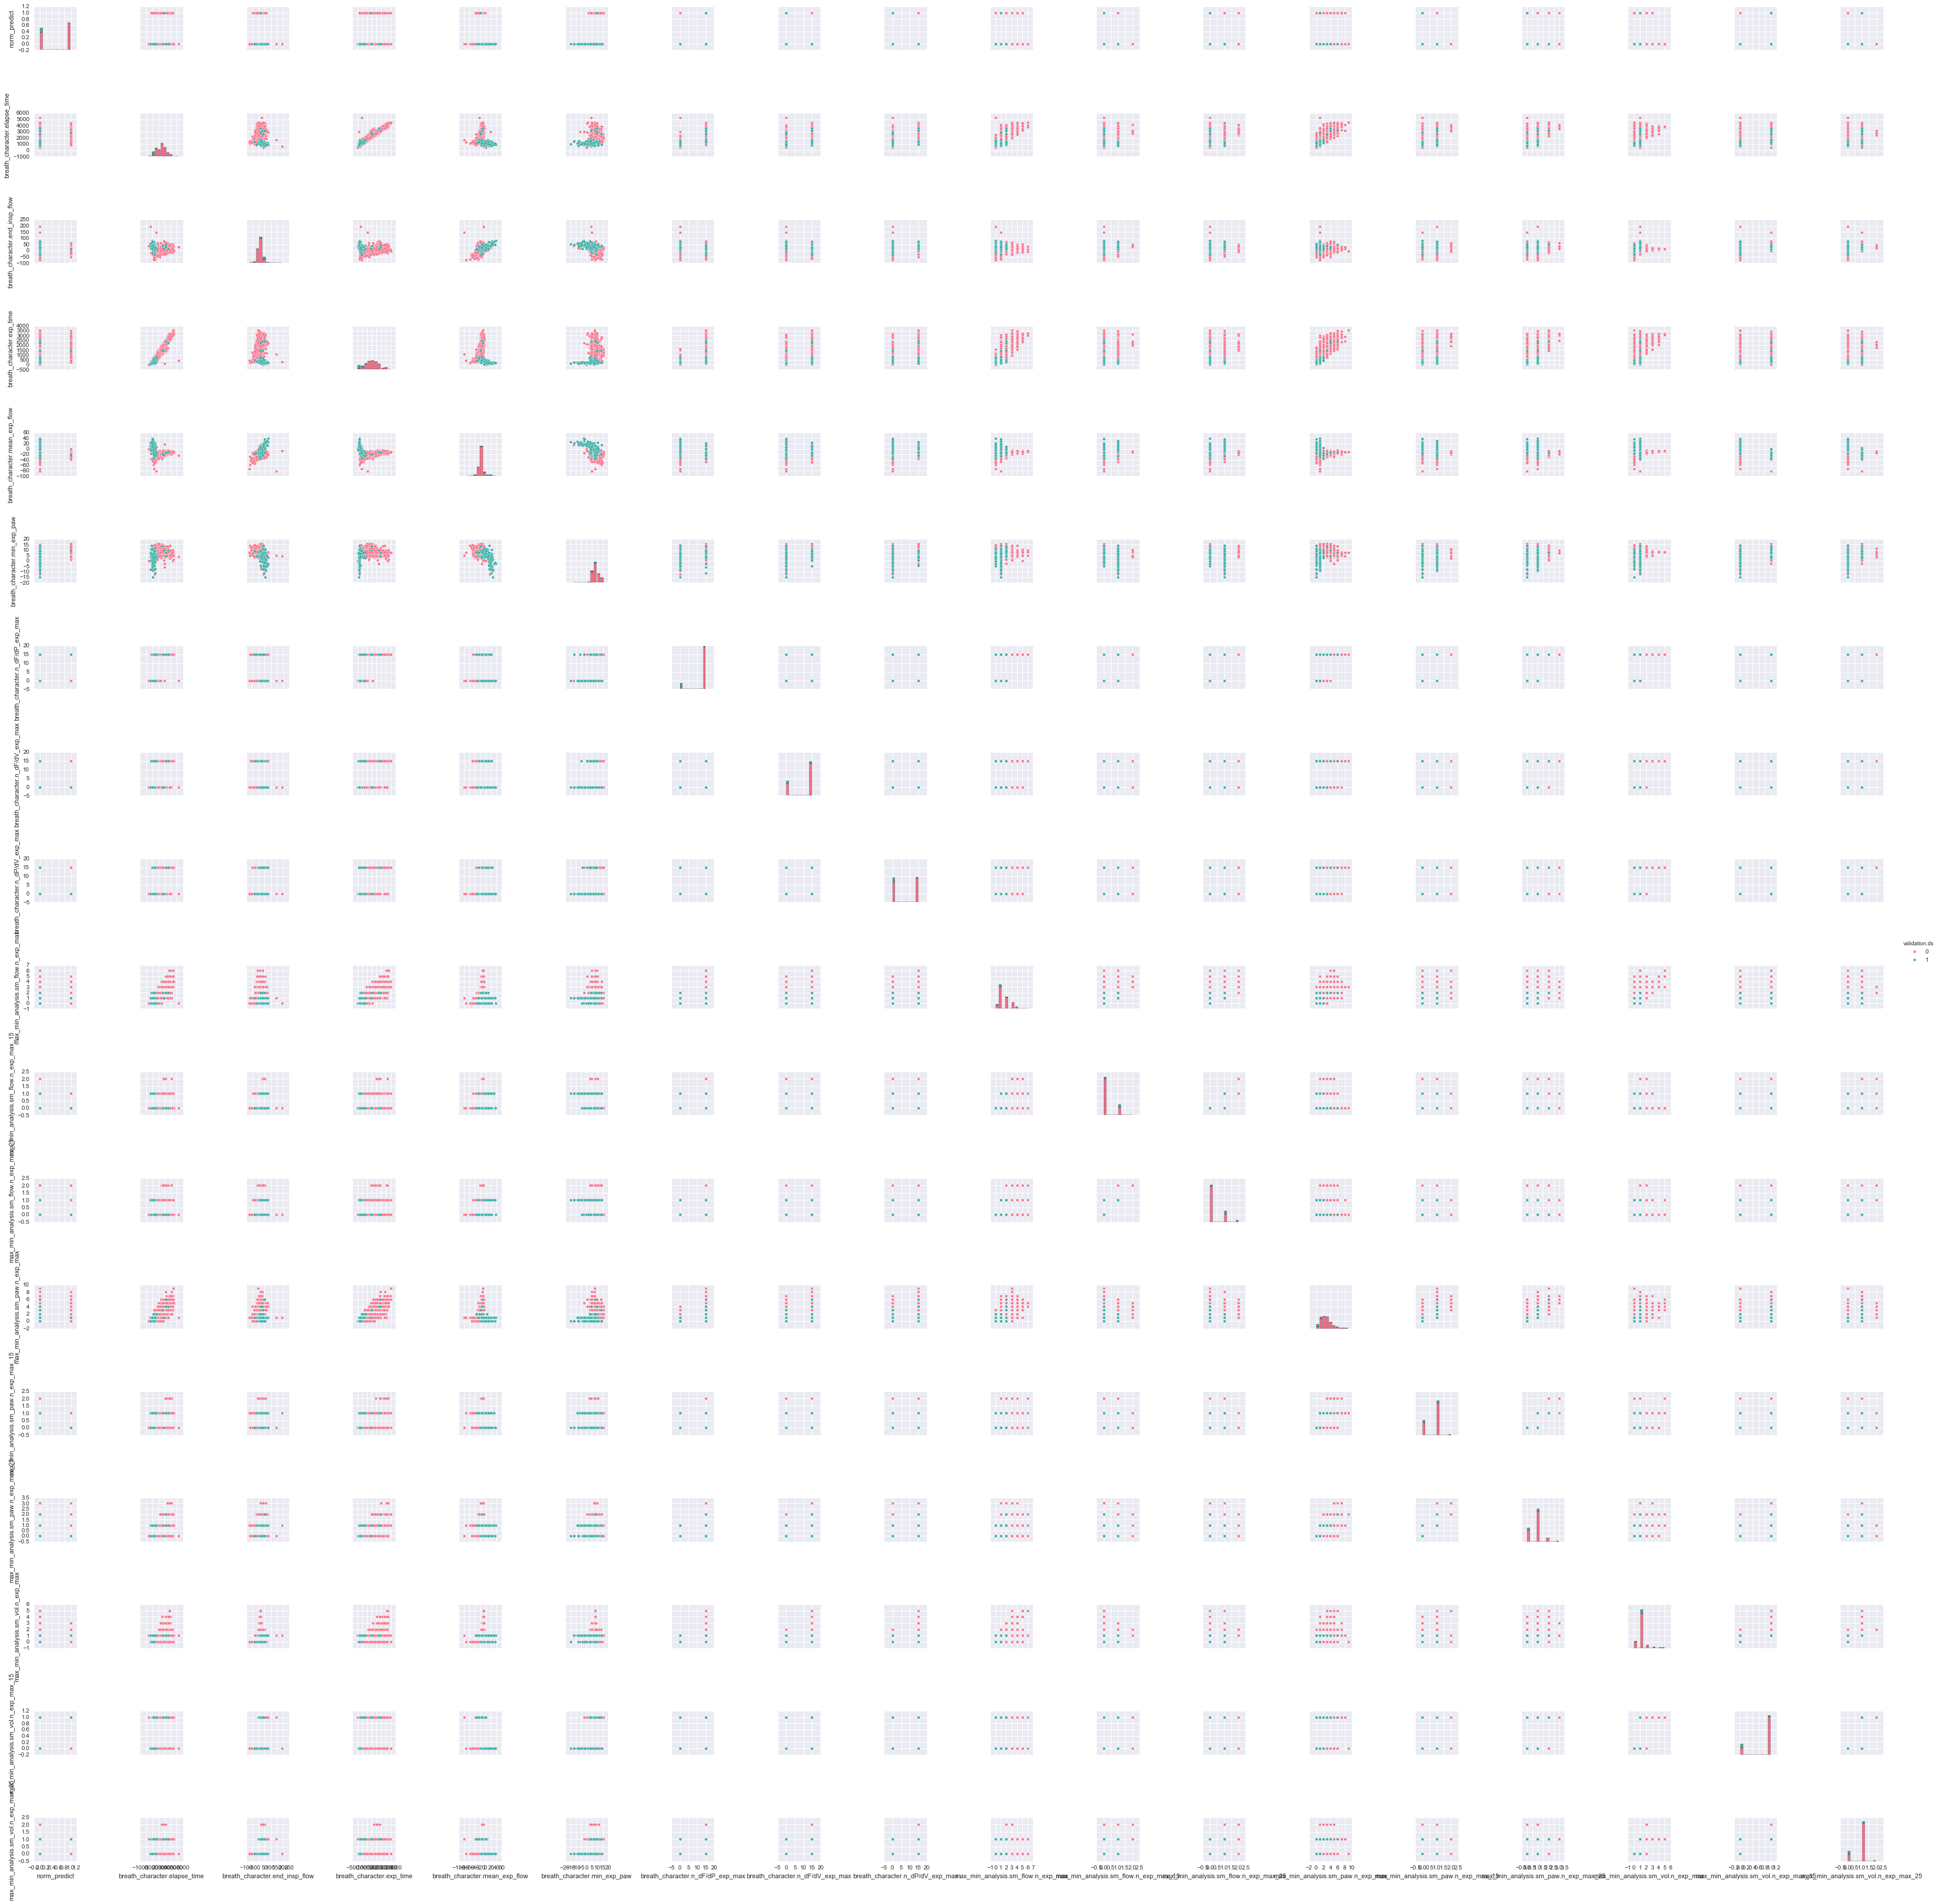

In [37]:
rows = pvt_cols

sb.pairplot(df, hue='validation.ds', palette='husl', vars = rows)